# Testing registration methods on Vivek's data

## Imports and magics

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import affine_transform
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from otimage import imagerep, io
from otimage.utils import plot_maxproj
from otimage.imagereg import ot_registration, gw_registration

## Load data

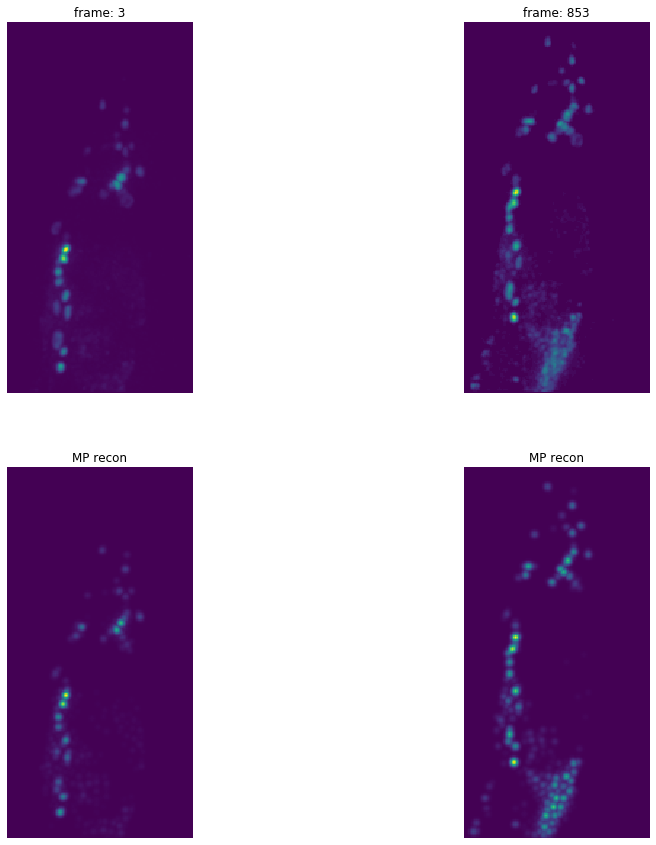

In [3]:
# Frame index
t1 = 3
t2 = 853

# Load two successive frames from dataset
img_path = '/home/mn2822/Desktop/WormTraces/data/Vivek/1024_tail_06/data.mat'
with io.VivekReader(img_path) as reader:
    img_1 = reader.get_frame(t1)
    img_2 = reader.get_frame(t2)
    
# Load MP components
mp_path = '/home/mn2822/Desktop/WormOT/data/vivek/1024_tail_06/mp_components/mp_0000_0900.mat'
with io.MPReader(mp_path) as reader:
    mp_1 = reader.get_frame(t1)
    mp_2 = reader.get_frame(t2)

# Reconstruct images from MPs
rec_1 = imagerep.reconstruct_mp_image(mp_1)
rec_2 = imagerep.reconstruct_mp_image(mp_2)
  
plt.figure(figsize=(15, 15))

plt.subplot(221)
plot_maxproj(img_1)
plt.title(f'frame: {t1}')
plt.axis('off')

plt.subplot(222)
plot_maxproj(img_2)
plt.title(f'frame: {t2}')
plt.axis('off');

plt.subplot(223)
plot_maxproj(rec_1)
plt.title('MP recon')
plt.axis('off')

plt.subplot(224)
plot_maxproj(rec_2)
plt.title('MP recon')
plt.axis('off');

## Run OT registration on images 

In [4]:
model, debug = gw_registration(mp_1, mp_2, degree=3, n_iter=75)

print('beta (est):')
print(model.beta)

beta (est):
[[-1.21044477e+02  5.20010047e+00  2.28597290e+00  1.91024961e+01
  -3.19654663e-02 -6.19885704e-02 -1.92077282e-01 -1.33120773e-02
  -2.39937640e-02 -1.52276992e+00 -8.58969478e-05  6.40072290e-04
  -1.81565171e-04  1.24777548e-05 -9.15590906e-04  8.82470304e-03
   2.64088173e-05  6.36531607e-04 -1.70191708e-04  3.76082107e-02]
 [ 1.55967432e+01 -3.68988867e+00  2.58948900e-01  2.10304370e+01
   1.48844165e-01 -7.01532173e-02 -4.69071911e-01  3.88671674e-02
  -2.84230030e-01 -3.26229865e-01 -1.49674840e-03  1.29477729e-03
   4.77741675e-03 -5.07828678e-04  1.63245173e-04 -3.00620857e-03
  -9.67568608e-07  1.26784691e-04  9.89833429e-03  2.36537320e-03]
 [-7.85450976e+00  9.37394877e-01  3.17089717e-02  1.05836483e+00
  -1.38952273e-02  7.85641912e-04 -3.27339410e-02 -2.17266171e-03
   1.52915002e-02 -5.72627629e-02  7.18125372e-05 -5.41621776e-06
   5.02048508e-05  1.60449132e-05 -1.57602417e-04  1.50086716e-03
   3.54608796e-06 -1.10876113e-06 -2.59983781e-04  2.13553754e

## Reconstruct second frame using mapping

### MP space

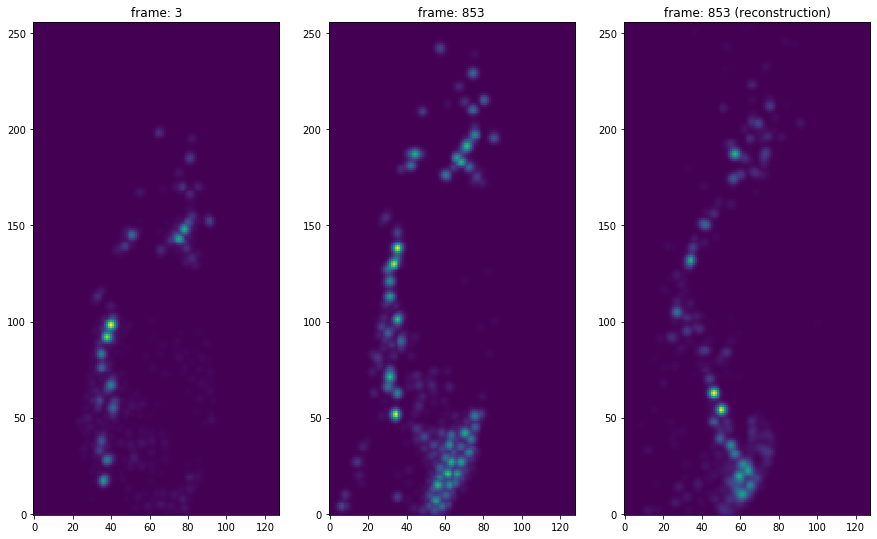

In [5]:
# Transform MP points for first image using mapping
pf_pts = model.predict(mp_1.pts).astype(int)

# Reconstruct image from transformed points
mp_pf = imagerep.ImageMP(pf_pts, mp_1.wts, mp_1.cov, mp_1.img_shape)
rec_pf = imagerep.reconstruct_mp_image(mp_pf)

plt.figure(figsize=(15, 15))

plt.subplot(131)
plot_maxproj(rec_1)
plt.title(f'frame: {t1}')
        
plt.subplot(132)
plot_maxproj(rec_2)
plt.title(f'frame: {t2}')
        
plt.subplot(133)
plot_maxproj(rec_pf)
plt.title(f'frame: {t2} (reconstruction)');

## Changes in mapping over iterations

### Coordinates of single MP point

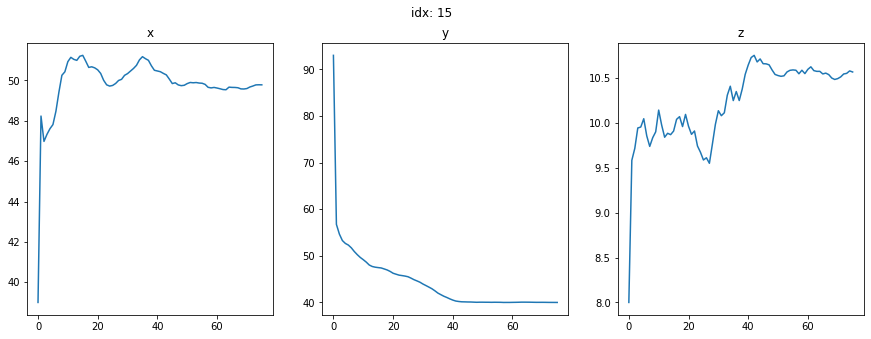

In [6]:
idx = 15

x_vals = [p[idx, 0] for p in debug['pf_pts']]
y_vals = [p[idx, 1] for p in debug['pf_pts']]
z_vals = [p[idx, 2] for p in debug['pf_pts']]

plt.figure(figsize=(15, 5))
plt.suptitle(f'idx: {idx}')

plt.subplot(131)
plt.plot(x_vals)
plt.title('x')

plt.subplot(132)
plt.plot(y_vals)
plt.title('y')

plt.subplot(133)
plt.plot(z_vals);
plt.title('z');

### MP reconstruction of entire image

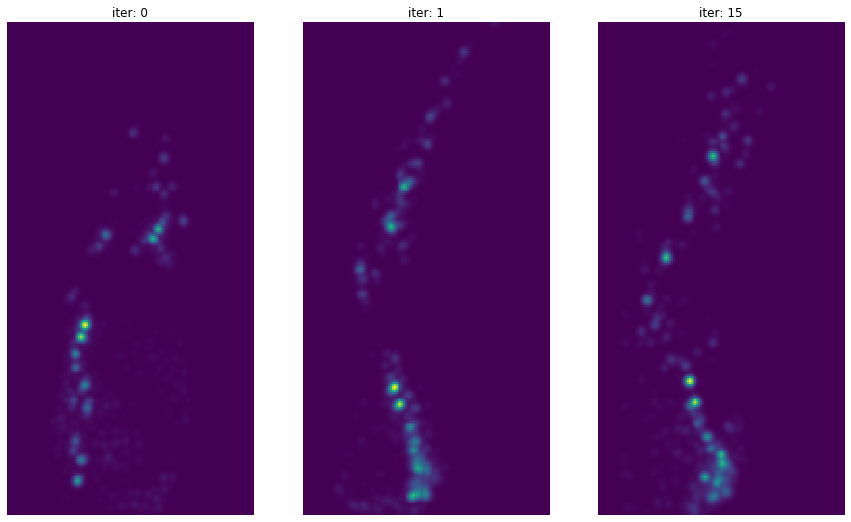

In [7]:
iters = [0, 1, 15]

trans_mps = [imagerep.ImageMP(debug['pf_pts'][i], mp_1.wts, mp_1.cov, mp_1.img_shape) for i in iters]
trans_rec = [imagerep.reconstruct_mp_image(mp) for mp in trans_mps]

plt.figure(figsize=(15, 15))

plt.subplot(131)
plot_maxproj(trans_rec[0])
plt.title(f'iter: {iters[0]}')
plt.axis('off')
        
plt.subplot(132)
plot_maxproj(trans_rec[1])
plt.title(f'iter: {iters[1]}')
plt.axis('off')
        
plt.subplot(133)
plot_maxproj(trans_rec[2])
plt.title(f'iter: {iters[2]}')
plt.axis('off');